In [4]:
# %pip install desdeo

# Data generation
* Find a method that can generate artificial data based on mean and variance
* If a method cannot be found, need to assume distriubtion
    * something in R? Also in Python, I think and making a function for that would not be too difficult. 
    * Could check the distribution from existing data and just go with that, even though it might or might not be accurate.

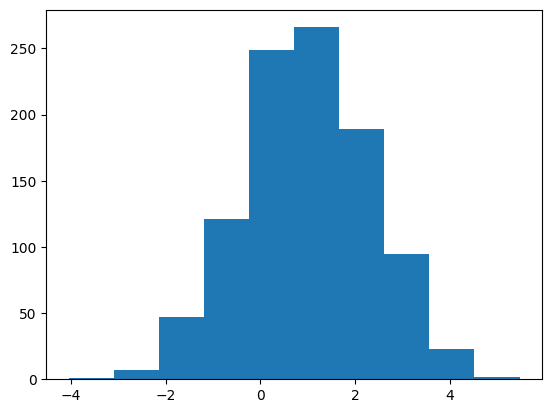

In [6]:
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt

# Generating data following the normal distrubution
variance = 2  # just an example value
standard_deviation = sqrt(variance)  # Standard deviation is the square root of the variance
mean = 1  # another example value
n = 1000  # the amount of samples to be generated

values = np.random.normal(mean, standard_deviation, n)
#print(values)

plt.hist(values)
plt.show() 

# Problem object formulation
Implement the problem object based on the data. We need to 
* create variables
* create the objective functions
* create the constraint
* stuff it all into the MOProblem object thingie
* calculate ideal and nadir to show to the imaginary DM

In [2]:
import desdeo

# TODO: his could maybe be divided into more cells
# Variables
# Objectives
# Constraints
# Forming the objective function

In [ ]:
# Ideal and nadir

# Choosing a method 
We need to do some trickery here (I think) since the preference information is provided as ranges, not precise points. I'm not sure if the preference can be given as a range to the desdeo preference point method. 

# Preferences provided by the DM 
Acceptable minimum and maximum ranges for the objectives

| |Costs (€) | Pain change (%) | Function change (%) | Supervised sessions | Period (weeks) |
| -------|------------|------------------|----------------------|----------------------|----------------|
| Iteration 1 | 300 | +30% | +25% | 0 | 8 |
| | 600 | +15% | +15% | 15 | 26 |
| Iteration 2  | 200 | +25% | +40% | 0 | 12 |
| | 500 | +15% | +15% | 30 | 26 |
